In [25]:
import os
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2

st.header('Flower Classification CNN Model')
flower_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Load your Keras model
model = tf.keras.models.load_model('Flower_Recog_Model.keras')

def classify_image(image):
    input_image = cv2.resize(image, (180, 180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)
    
    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

# Webcam capture
cap = cv2.VideoCapture(0)

# Streamlit layout
col1, col2 = st.columns(2)

with col1:
    # Display the webcam feed
    frame_placeholder = st.empty()

with col2:
    # Display the classification result
    result_placeholder = st.empty()

while True:
    ret, frame = cap.read()
    if not ret:
        st.error("Failed to capture image from webcam.")
        break

    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame
    frame_placeholder.image(frame_rgb, channels="RGB")

    # Classify the image
    result = classify_image(frame_rgb)
    
    # Display the result
    result_placeholder.text(result)

    # Check if the user wants to stop
    if st.button('Stop'):
        break

# Release the webcam
cap.release()

In [27]:
count = 0 
dirs = os.listdir('Images/')
for dir in dirs:
    files = list(os.listdir('Images/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')


daisy Folder has 764 Images
dandelion Folder has 1052 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
tulip Folder has 984 Images
Images Folder has 4317 Images


In [29]:
base_dir = 'Images/'
img_size = 180
batch = 32

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [33]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [35]:
import matplotlib.pyplot as plt

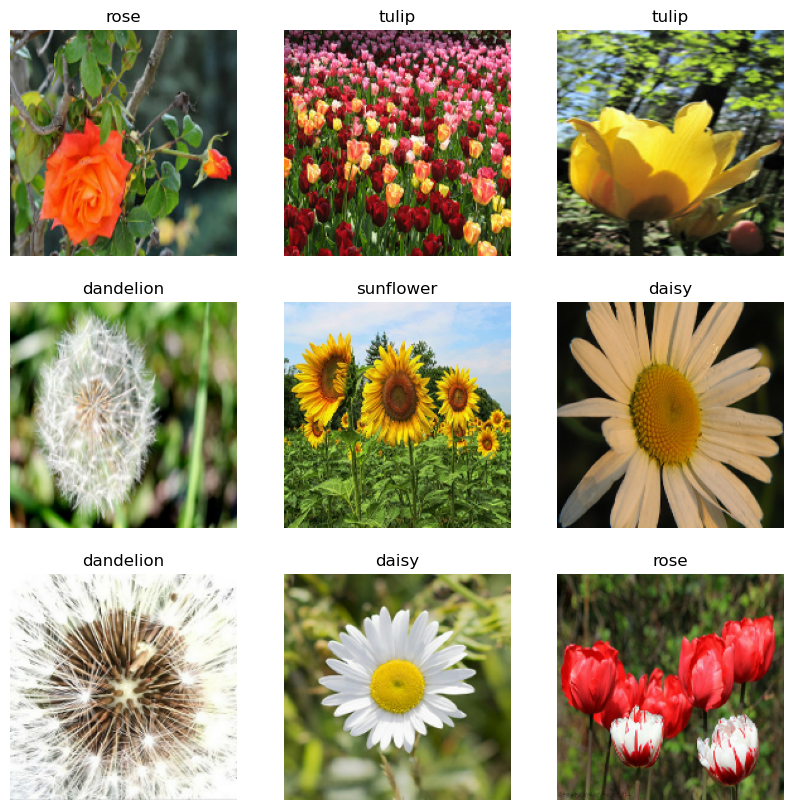

In [37]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [43]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [47]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

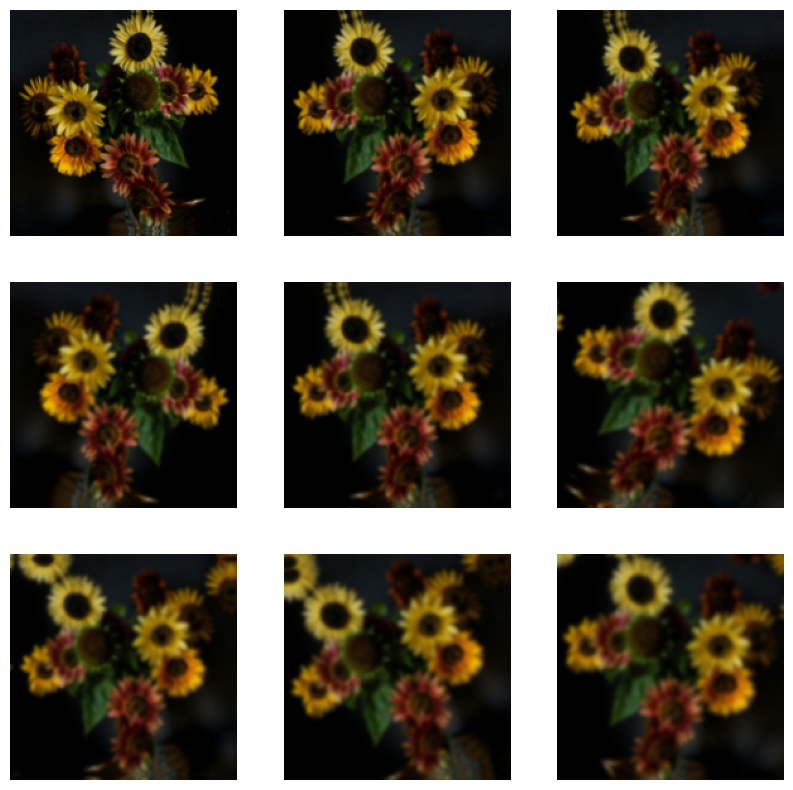

In [51]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [53]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.3995 - loss: 1.4399 - val_accuracy: 0.5481 - val_loss: 1.1307
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.5752 - loss: 1.0568 - val_accuracy: 0.5886 - val_loss: 1.0125
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.6435 - loss: 0.9414 - val_accuracy: 0.6385 - val_loss: 0.9241
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.6768 - loss: 0.8628 - val_accuracy: 0.6651 - val_loss: 0.8574
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.6729 - loss: 0.8297 - val_accuracy: 0.6698 - val_loss: 0.8396
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.7007 - loss: 0.7971 - val_accuracy: 0.6698 - val_loss: 0.8435
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 248ms/step - accuracy: 0.7120 - loss: 0.7649 - val_accuracy: 0.6790 - val_loss: 0.8166
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.7129 - loss: 0

In [111]:
import tensorflow as tf
import numpy as np
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [113]:
classify_images('Sample/rose.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


'The Image belongs to rose with a score of 99.79791045188904'

In [123]:
model.save('Flower_Recog_Model.keras')